In [1]:
import tensorflow as tf
import zipfile
import os
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, MobileNetV2, MobileNetV3Small, EfficientNetV2S, VGG19, ResNet50
from keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
data_dir = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"

In [3]:
def create_dataset_splits(data_dir, batch_size=32, img_size=(224, 224)):
    """
    Create train, validation, and test data generators from a single directory
    with a 70-20-10 split ratio.
    """
    # Create temporary directories for splits
    base_temp_dir = "/tmp/dataset_splits"
    train_dir = os.path.join(base_temp_dir, "train")
    val_dir = os.path.join(base_temp_dir, "val")
    test_dir = os.path.join(base_temp_dir, "test")
    
    # Clean up if temporary directories exist
    if os.path.exists(base_temp_dir):
        shutil.rmtree(base_temp_dir)
    
    # Get all image files and their labels
    classes = os.listdir(data_dir)
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_idx)
    
    # First split: 70% train, 30% temp
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, 
        train_size=0.7,
        random_state=42,
        stratify=labels
    )
    
    # Second split: 20% test, 10% validation (from the remaining 30%)
    test_paths, val_paths, test_labels, val_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=0.33,  # 0.33 of 30% is ~10% of total
        random_state=42,
        stratify=temp_labels
    )
    
    # Create split directories and copy files
    for split_dir, split_paths in [
        (train_dir, train_paths),
        (val_dir, val_paths),
        (test_dir, test_paths)
    ]:
        # Create class subdirectories
        for class_name in classes:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)
        
        # Copy files to appropriate split/class directories
        for path in split_paths:
            class_name = os.path.basename(os.path.dirname(path))
            filename = os.path.basename(path)
            dest_dir = os.path.join(split_dir, class_name)
            shutil.copy2(path, os.path.join(dest_dir, filename))
    
    # Create ImageDataGenerator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    # Create generators for each split
    train_gen = datagen.flow_from_directory(
        directory=train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    val_gen = datagen.flow_from_directory(
        directory=val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    test_gen = datagen.flow_from_directory(
        directory=test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen

batch_size = 32

train_generator, val_generator, test_generator = create_dataset_splits(
    data_dir,
    batch_size=batch_size,
    img_size=(224, 224)
)

Found 17498 images belonging to 2 classes.
Found 2475 images belonging to 2 classes.
Found 5025 images belonging to 2 classes.


In [4]:
# Load the EfficientNetB0 model with pretrained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False)
# Add GlobalAveragePooling2D layer after the EfficientNetB0 base
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Create the new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Function to extract features using the model and generator
def extract_features(generator):
    # Get the number of samples in the generator
    num_samples = generator.samples
    # Convert the ceiling of the division to an integer
    steps = int(np.ceil(num_samples / batch_size))
    # Predict features for the entire dataset in the generator
    features = model.predict(generator, steps=steps)
    return features

# Extract features from both train and test sets
train_features = extract_features(train_generator)
test_features = extract_features(test_generator)

# Output the shapes of the extracted features
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


526/547 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


547/547 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step
Train features shape: (17498, 1280)
Test features shape: (5025, 1280)


In [6]:
# Initialize the CatBoostClassifier with verbose for progress bar
cbc = CatBoostClassifier(
    iterations=2000,
    random_state=42,
    verbose=100,  # Show progress every 100 iterations
    eval_metric="Accuracy"
)

# Fit the model
cbc_fit = cbc.fit(train_features, train_generator.classes)

# Predict and evaluate the model
cbc_pred = cbc_fit.predict(test_features)
acc_CBC = accuracy_score(test_generator.classes, cbc_pred)
print("Accuracy: %.2f%%" % (acc_CBC * 100.0))
print(classification_report(test_generator.classes, cbc_pred, digits=4))

Learning rate set to 0.01852
0:	learn: 0.9542805	total: 347ms	remaining: 11m 34s
100:	learn: 0.9862841	total: 21.7s	remaining: 6m 47s
200:	learn: 0.9917705	total: 41.4s	remaining: 6m 10s
300:	learn: 0.9943994	total: 1m 1s	remaining: 5m 45s
400:	learn: 0.9957138	total: 1m 20s	remaining: 5m 21s
500:	learn: 0.9967996	total: 1m 40s	remaining: 4m 59s
600:	learn: 0.9975426	total: 1m 59s	remaining: 4m 38s
700:	learn: 0.9984570	total: 2m 18s	remaining: 4m 16s
800:	learn: 0.9990856	total: 2m 37s	remaining: 3m 56s
900:	learn: 0.9996000	total: 2m 57s	remaining: 3m 35s
1000:	learn: 0.9996571	total: 3m 16s	remaining: 3m 16s
1100:	learn: 0.9997143	total: 3m 35s	remaining: 2m 56s
1200:	learn: 0.9997143	total: 3m 54s	remaining: 2m 36s
1300:	learn: 0.9998286	total: 4m 14s	remaining: 2m 16s
1400:	learn: 0.9998286	total: 4m 33s	remaining: 1m 56s
1500:	learn: 0.9998857	total: 4m 52s	remaining: 1m 37s
1600:	learn: 0.9998857	total: 5m 11s	remaining: 1m 17s
1700:	learn: 0.9998857	total: 5m 30s	remaining: 58.

 2/78 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step
Validation Accuracy: 98.83%
              precision    recall  f1-score   support

           0     0.9911    0.9854    0.9882      1237
           1     0.9855    0.9911    0.9883      1238

    accuracy                         0.9883      2475
   macro avg     0.9883    0.9883    0.9883      2475
weighted avg     0.9883    0.9883    0.9883      2475



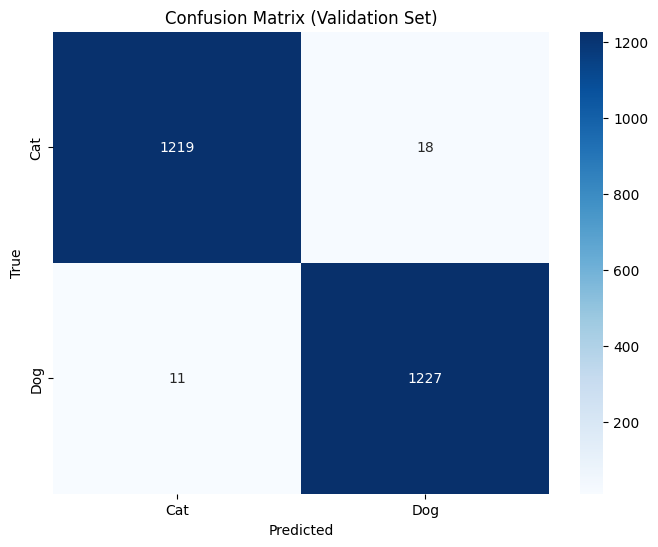

In [7]:
# Extract features from the validation set
val_features = extract_features(val_generator)

# Evaluate the model on the validation set
val_pred = cbc_fit.predict(val_features)
val_acc = accuracy_score(val_generator.classes, val_pred)
print("Validation Accuracy: %.2f%%" % (val_acc * 100.0))
print(classification_report(val_generator.classes, val_pred, digits=4))

# Confusion matrix for validation set
val_cm = confusion_matrix(val_generator.classes, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

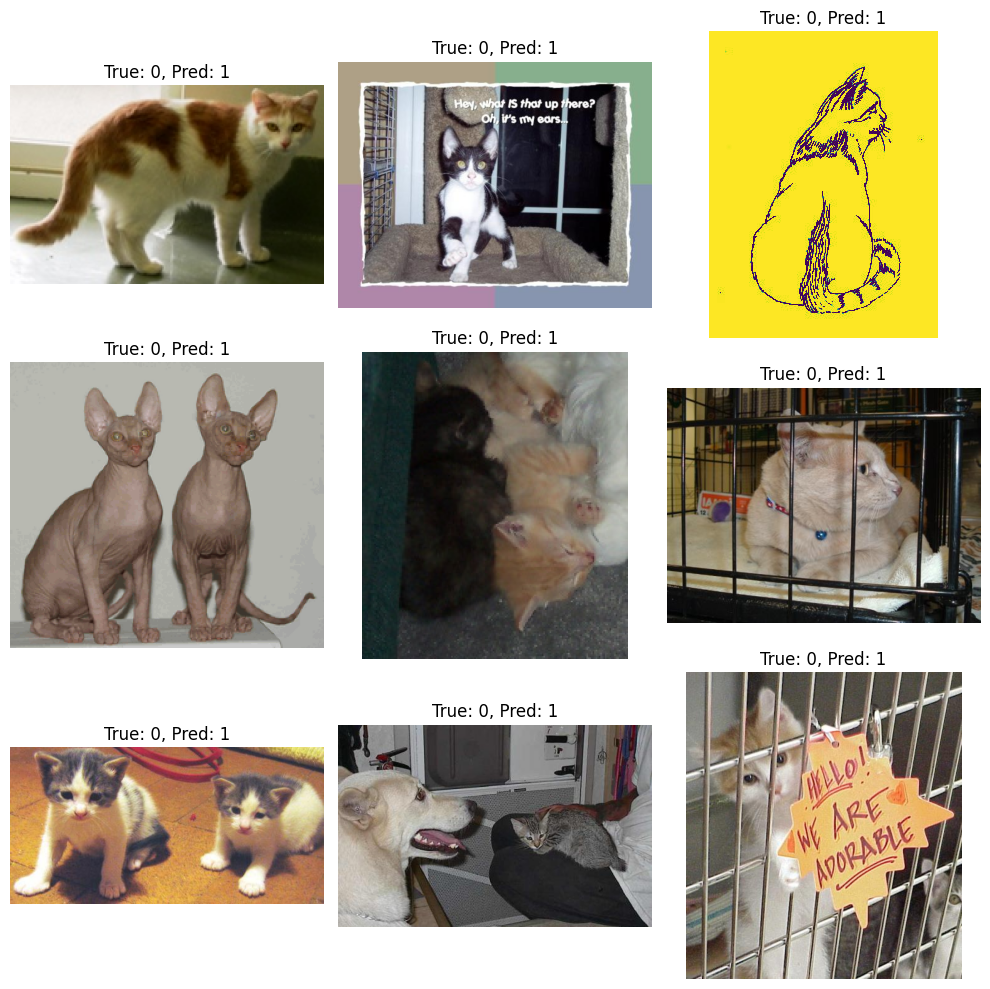

In [8]:
# Get the indices of false positives
false_positives = np.where((val_pred != val_generator.classes) & (val_pred == 1))[0]

# Display false positive images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(false_positives[:9]):  # Display up to 9 false positives
    plt.subplot(3, 3, i + 1)
    img_path = val_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"True: {val_generator.classes[idx]}, Pred: {val_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

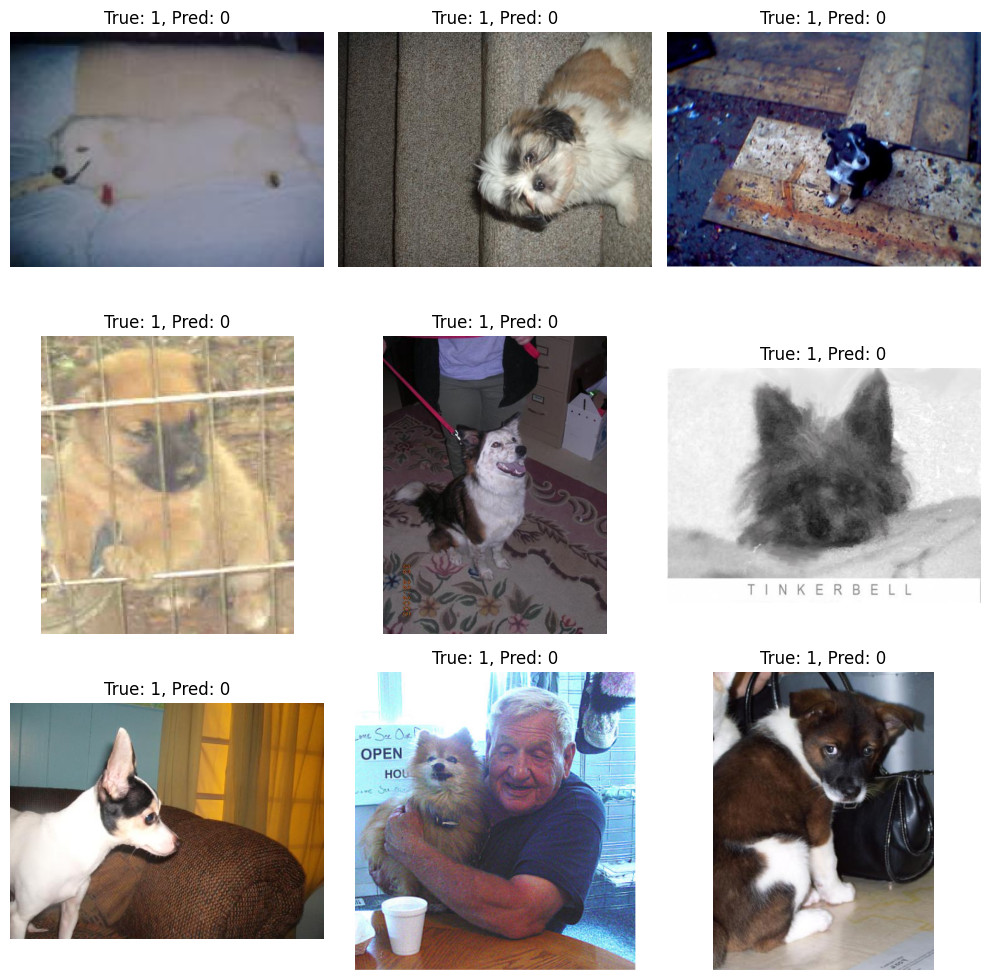

In [9]:
# Get the indices of false negatives
false_negatives = np.where((val_pred != val_generator.classes) & (val_pred == 0))[0]

# Display false negative images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(false_negatives[:9]):  # Display up to 9 false negatives
    plt.subplot(3, 3, i + 1)
    img_path = val_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"True: {val_generator.classes[idx]}, Pred: {val_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


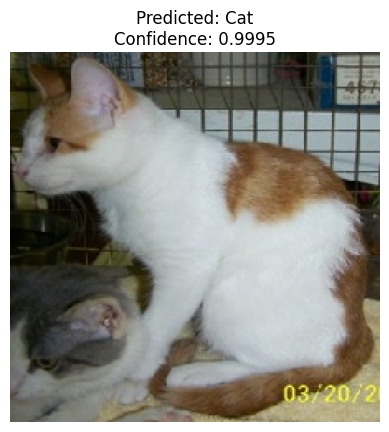

In [10]:
# Get all cat image indices from the validation generator
cat_class_idx = list(train_generator.class_indices.values())[list(train_generator.class_indices.keys()).index('Cat')]
cat_indices = [i for i, label in enumerate(val_generator.classes) if label == cat_class_idx]

# Pick a random cat image index
random_cat_idx = random.choice(cat_indices)
random_cat_path = val_generator.filepaths[random_cat_idx]

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(random_cat_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Extract features using the model
features = model.predict(img_array)

# Predict using CatBoost
prediction = cbc_fit.predict(features)
confidence = cbc_fit.predict_proba(features)[0]

# Get the predicted class and confidence
predicted_class = list(train_generator.class_indices.keys())[prediction[0]]
confidence_score = confidence[prediction[0]]

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.4f}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


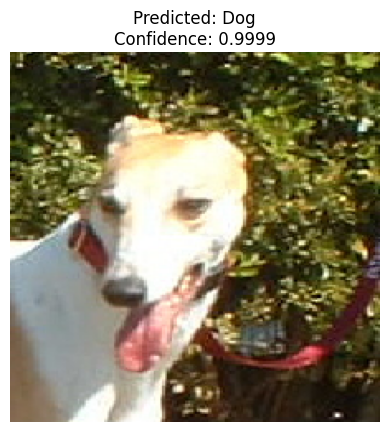

In [11]:
# Get all dog image indices from the validation generator
dog_class_idx = list(train_generator.class_indices.values())[list(train_generator.class_indices.keys()).index('Dog')]
dog_indices = [i for i, label in enumerate(val_generator.classes) if label == dog_class_idx]

# Pick a random dog image index
random_dog_idx = random.choice(dog_indices)
random_dog_path = val_generator.filepaths[random_dog_idx]

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(random_dog_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Extract features using the model
features = model.predict(img_array)

# Predict using CatBoost
prediction = cbc_fit.predict(features)
confidence = cbc_fit.predict_proba(features)[0]

# Get the predicted class and confidence
predicted_class = list(train_generator.class_indices.keys())[prediction[0]]
confidence_score = confidence[prediction[0]]

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.4f}")
plt.axis('off')
plt.show()

In [12]:
cbc_fit.save_model('catboost_dog_cat_classifier.cbm')

model.save('efficientnetb0_dog_cat_feature_extractor.h5')

print("Models saved successfully!")

Models saved successfully!
